/Users/pdg/Library/Python/3.9/lib/python/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Reward = -1401.9013640772391, Actor Loss = 11.030627250671387, Critic Loss = 0.4156322479248047
Episode 2: Reward = -1060.8984543816398, Actor Loss = 16.855703353881836, Critic Loss = 0.14996981620788574
Episode 3: Reward = -1620.3719577473391, Actor Loss = 23.03399085998535, Critic Loss = 2.1611487865448
Episode 4: Reward = -1600.8041766958106, Actor Loss = 24.50152587890625, Critic Loss = 0.6751425862312317
Episode 5: Reward = -1583.7916700234434, Actor Loss = 32.64262390136719, Critic Loss = 0.8482077717781067
Episode 6: Reward = -1679.1136360744445, Actor Loss = 39.22941970825195, Critic Loss = 10.35230827331543
Episode 7: Reward = -1850.3447680575218, Actor Loss = 47.2625617980957, Critic Loss = 52.215057373046875
Episode 8: Reward = -1833.6714977579634, Actor Loss = 51.879249572753906, Critic Loss = 38.31324768066406
Episode 9: Reward = -1742.6027978126444, Actor Loss = 61.51283645629883, Critic Loss = 1.8156832456588745
Episode 10: Reward = -1095.9113782971567, Actor 

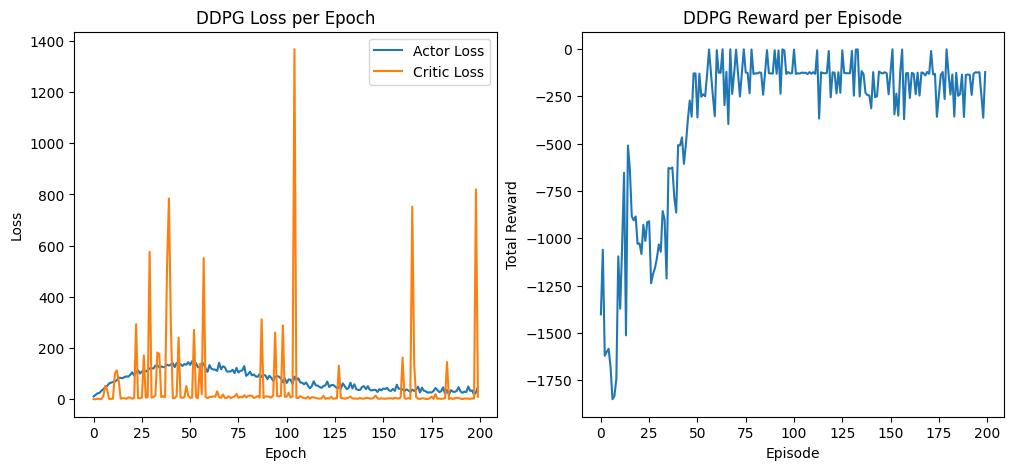

Video saved at: ddpg_videos/ddpg_pendulum.gif
If you encounter pygame errors, please install using: pip install gym[classic_control] and pip install pygame
If you encounter FFMPEG errors, please install using: pip install imageio[ffmpeg]


In [5]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
import imageio
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size=100000):
        self.buffer = deque(maxlen=max_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done

    def size(self):
        return len(self.buffer)

# Actor Network for DDPG
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.layer_1 = nn.Linear(state_dim, 400)
        self.layer_2 = nn.Linear(400, 300)
        self.layer_3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = torch.relu(self.layer_1(state))
        x = torch.relu(self.layer_2(x))
        x = torch.tanh(self.layer_3(x))
        return x * self.max_action

# Critic Network for DDPG
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.layer_1 = nn.Linear(state_dim + action_dim, 400)
        self.layer_2 = nn.Linear(400, 300)
        self.layer_3 = nn.Linear(300, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = torch.relu(self.layer_1(x))
        x = torch.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

# DDPG Agent
class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = max_action
        self.replay_buffer = ReplayBuffer()
        self.gamma = 0.99
        self.tau = 0.005

    def select_action(self, state):
        state = torch.FloatTensor(np.array(state).reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, batch_size=64):
        if self.replay_buffer.size() < batch_size:
            return None, None

        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)

        state = torch.FloatTensor(state).to(device)
        action = torch.FloatTensor(action).to(device)
        reward = torch.FloatTensor(reward).reshape((batch_size, 1)).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        done = torch.FloatTensor(1 - done).reshape((batch_size, 1)).to(device)

        # Critic loss
        target_Q = self.critic_target(next_state, self.actor_target(next_state))
        target_Q = reward + (done * self.gamma * target_Q).detach()
        current_Q = self.critic(state, action)

        critic_loss = nn.MSELoss()(current_Q, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor loss
        actor_loss = -self.critic(state, self.actor(state)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        return actor_loss.item(), critic_loss.item()

# Training Loop
env = gym.make('Pendulum-v1', render_mode="rgb_array")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

ddp_agent = DDPGAgent(state_dim, action_dim, max_action)

num_episodes = 200
epoch_actor_losses = []
epoch_critic_losses = []
rewards_per_episode = []

for episode in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0

    for step in range(200):
        action = ddp_agent.select_action(state)
        next_state, reward, done, truncated, _ = env.step(action)
        ddp_agent.replay_buffer.add(state, action, reward, next_state, float(done or truncated))

        actor_loss, critic_loss = ddp_agent.train()

        state = next_state
        episode_reward += reward

    if actor_loss is not None and critic_loss is not None:
        epoch_actor_losses.append(actor_loss)
        epoch_critic_losses.append(critic_loss)

    rewards_per_episode.append(episode_reward)

    print(f"Episode {episode+1}: Reward = {episode_reward}, Actor Loss = {actor_loss}, Critic Loss = {critic_loss}")

# Plotting loss and reward
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_actor_losses, label='Actor Loss')
plt.plot(epoch_critic_losses, label='Critic Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DDPG Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DDPG Reward per Episode')

plt.show()

# Task 5: Record and save a video
video_dir = 'ddpg_videos'
os.makedirs(video_dir, exist_ok=True)

def record_video(agent, max_steps=200):
    env = gym.make('Pendulum-v1', render_mode="rgb_array")
    frames = []
    state, _ = env.reset()

    for step in range(max_steps):
        frame = env.render()
        frames.append(frame)

        action = agent.select_action(state)
        next_state, reward, done, truncated, _ = env.step(action)

        if done or truncated:
            break

        state = next_state

    env.close()
    return frames

# Record and save a video of the trained agent
video_frames = record_video(ddp_agent)
video_filename = os.path.join(video_dir, 'ddpg_pendulum.gif')
imageio.mimsave(video_filename, video_frames, fps=30)

print(f"Video saved at: {video_filename}")

print("If you encounter pygame errors, please install using: pip install gym[classic_control] and pip install pygame")
print("If you encounter FFMPEG errors, please install using: pip install imageio[ffmpeg]")
